# Nitrogen Dioxide - AURA OMI

- **Key ideas:**
    - Exploring global `monthly` gridded `0.10 x 0.10°` L3 NO2 concentration data in South America and Southeastern Brazil. 
    - Is it possible to see the effect of covid19 lockdown in data?

## Initial setup

In [1]:
# Load packages.
import sys
import os
import glob
import warnings
import cmocean

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.stats import linregress

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")

%matplotlib inline                                                                            

In [2]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package (work in progress).
import cdlearn

In [3]:
# Main directory.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/AURA_OMI_NO2/L3_monthly_010/"

In [4]:
# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/single_variables/"

In [5]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Preprocess data

In [6]:
# All files.
FILES = sorted(glob.glob(DATA_FOLDER + "/*.nc"))

# Some information.
print(">>>", len(FILES), "data files inside", DATA_FOLDER + ":")

for FILE in FILES[:5]:
    print("*", os.path.basename(FILE))
print("...")
for FILE in FILES[-5:]:
    print("*", os.path.basename(FILE))

>>> 187 data files inside /media/alex/ALEXDATA/data_sets/AURA_OMI_NO2/L3_monthly_010/:
* OMI_trno2_0.10x0.10_200410_Col3_V4.nc
* OMI_trno2_0.10x0.10_200411_Col3_V4.nc
* OMI_trno2_0.10x0.10_200412_Col3_V4.nc
* OMI_trno2_0.10x0.10_200501_Col3_V4.nc
* OMI_trno2_0.10x0.10_200502_Col3_V4.nc
...
* OMI_trno2_0.10x0.10_201912_Col3_V4.nc
* OMI_trno2_0.10x0.10_202001_Col3_V4.nc
* OMI_trno2_0.10x0.10_202002_Col3_V4.nc
* OMI_trno2_0.10x0.10_202003_Col3_V4.nc
* OMI_trno2_0.10x0.10_202004_Col3_V4.nc


### Single file

In [7]:
# Open a single file.
DS = xr.open_dataset(filename_or_obj=FILES[-1])

# Metadata.
DS

<xarray.Dataset>
Dimensions:          (nLat: 1800, nLon: 3600)
Dimensions without coordinates: nLat, nLon
Data variables:
    LatitudeCenter   (nLat) float32 ...
    LongitudeCenter  (nLon) float32 ...
    TroposphericNO2  (nLat, nLon) float32 ...
Attributes:
    Title:        OMI NO2
    Author:       Lok Lamsal (lok.lamsal@nasa.gov)
    Institution:  NASA GSFC
    History:      Created: 09/01/2020

In [8]:
# Tropospheric NO2 variable.
DS.TroposphericNO2

<xarray.DataArray 'TroposphericNO2' (nLat: 1800, nLon: 3600)>
[6480000 values with dtype=float32]
Dimensions without coordinates: nLat, nLon
Attributes:
    Long_name:  TroposphericNO2
    Units:      molec.cm-2

### All files

In [9]:
# Extract dates from names of data files.
DATEstr = []
for FILE in FILES:
    FNAME = os.path.basename(FILE)
    YEARstr = FNAME[20: 24]
    MONTHstr = FNAME[24: 26]
    DATEstr.append(MONTHstr + "-" + YEARstr)
    
# Pandas DateTimeIndex object.
TIME = pd.to_datetime(arg=DATEstr)

In [10]:
%%time

# Put all data together.
DS = xr.open_mfdataset(
    paths=FILES,
    concat_dim="time",
    combine="nested",
    data_vars=["TroposphericNO2"] # Only this variable will have time dimension.
)

# Rename and change order of dimensions.
DS = DS.rename_dims({"nLat": "lat", "nLon": "lon"})
DS = DS.transpose("time", "lat", "lon")

# Fill coordinates.
DS = DS.assign_coords({
    "time": TIME,
    "lat": DS.LatitudeCenter.values,
    "lon": DS.LongitudeCenter.values
})

# Drop variables.
DS = DS.drop_vars(["LongitudeCenter", "LatitudeCenter"])

# South America.
DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Show results.
DS

CPU times: user 4.52 s, sys: 145 ms, total: 4.67 s
Wall time: 4.78 s


<xarray.Dataset>
Dimensions:          (lat: 800, lon: 600, time: 187)
Coordinates:
  * time             (time) datetime64[ns] 2004-10-01 2004-11-01 ... 2020-04-01
  * lat              (lat) float32 -59.95 -59.850002 -59.75 ... 19.850002 19.95
  * lon              (lon) float32 -89.95 -89.85 ... -30.149998 -30.049992
Data variables:
    TroposphericNO2  (time, lat, lon) float32 dask.array<chunksize=(1, 800, 600), meta=np.ndarray>
Attributes:
    Title:        OMI NO2
    Author:       Lok Lamsal (lok.lamsal@nasa.gov)
    Institution:  NASA GSFC
    History:      Created: 09/01/2020

**DANGER ZONE!**

In [11]:
# Load into memory.
with ProgressBar():
    DS = DS.load()

[########################################] | 100% Completed |  2min  6.8s


In [12]:
# Only positive values.
NO2 = DS.TroposphericNO2.values
mask_plus = NO2 <= 0
NO2[mask_plus] = np.nan
DS.TroposphericNO2.values = NO2

>>> SCA: 1e+15
>>> MAX: 23.117214
>>> MIN: 1.5252015e-09
>>> AVG: 0.3303466

CPU times: user 3.11 s, sys: 1.91 s, total: 5.02 s
Wall time: 7.84 s


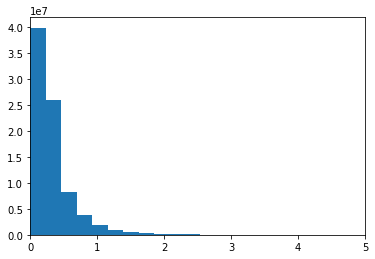

In [13]:
%%time

scale = 1e15
print(">>> SCA: {:.0e}".format(scale))
print(">>> MAX:", np.nanmax(NO2[~np.isnan(NO2)] / scale))
print(">>> MIN:", np.nanmin(NO2[~np.isnan(NO2)] / scale))
print(">>> AVG:", np.nanmean(NO2[~np.isnan(NO2)] / scale))
print("")

_ = plt.hist(NO2[~np.isnan(NO2)] / scale, bins=100)
_ = plt.xlim((0, 5))

In [14]:
%%time

# Export preprocessed data.
DS.to_netcdf(
    path="/media/alex/ALEXDATA/data_sets/AURA_OMI_NO2/ppdata_L3_monthly_010_south_america.nc",
    mode="w"
)

CPU times: user 20.8 ms, sys: 177 ms, total: 198 ms
Wall time: 584 ms


## Monthly means for all period

In [15]:
%%time

# Monthly mean.
NO2mm = DS.TroposphericNO2.groupby("time.month").mean("time")

CPU times: user 499 ms, sys: 17.7 ms, total: 516 ms
Wall time: 526 ms


CPU times: user 20.8 s, sys: 177 ms, total: 21 s
Wall time: 15.1 s


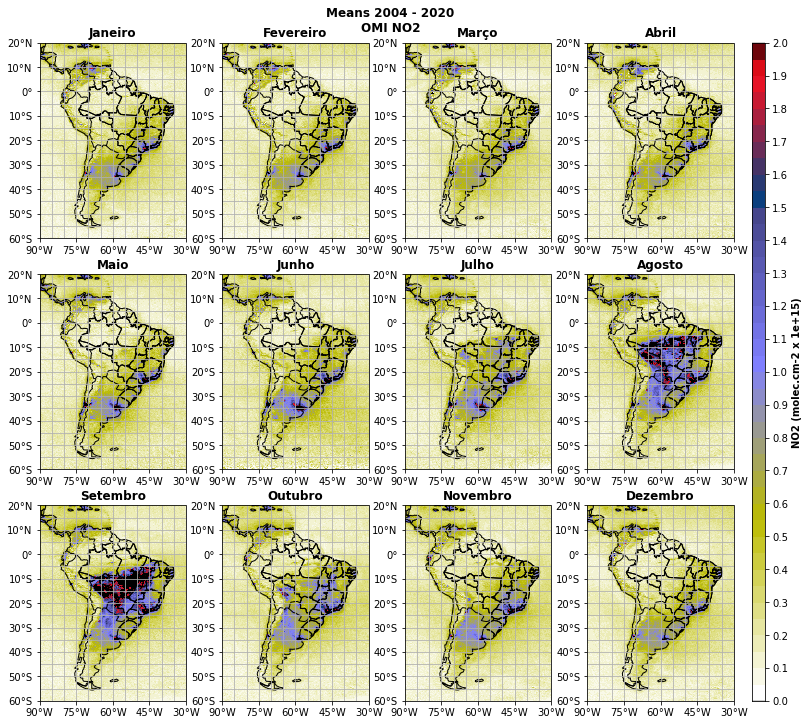

In [16]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(13, 12))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 4),
    axes_pad=0.5,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    scale = 1e15
    p = (NO2mm[index] / scale).plot(
        ax=axis,
        vmin=0,
        vmax=2,
        levels=np.arange(0, 2.05, 0.05),
        cmap=plt.cm.gist_stern_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(cdlearn.auxiliary.months_labels_pt[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(0, 2.1, 0.1))        
plt.suptitle("Means 2004 - 2020\n" + DS.attrs["Title"], weight="bold")
plt.subplots_adjust(top=0.99)

# Save figures.
plt.savefig(fig_path + "no2_omi_mmeans_pt.jpg", dpi=200, bbox_inches="tight")

## Anomalies for March and April

### Lockdown period is 2020

In [17]:
# Lockdown period.
mask_mar = DS.time.dt.month == 3
mask_apr = DS.time.dt.month == 4
mask_2020 = DS.time.dt.year == 2020
mask_lock = (mask_mar | mask_apr) & mask_2020
DS_lock = DS.sel(time=DS.time[mask_lock]).mean("time")

### Base period is 2004 - 2019

In [18]:
# March - April mean for the 2004-2019 period. 
mask_2004_2019 = np.logical_and(DS.time.dt.year >= 2004, DS.time.dt.year <= 2019)
mask_base = (mask_mar | mask_apr) & mask_2004_2019
DS_base = DS.sel(time=DS.time[mask_base]).mean("time")

CPU times: user 5.65 s, sys: 57.6 ms, total: 5.71 s
Wall time: 4.14 s


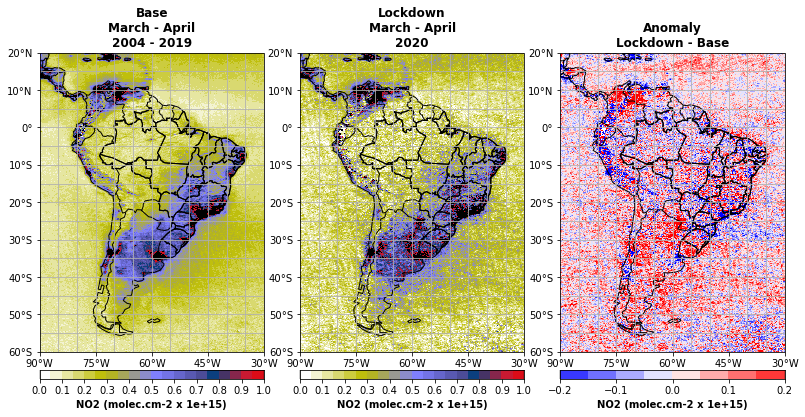

In [19]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(14, 6))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )        
    
# Plot data on these maps.
scale = 1e15

# Base period.
p = (DS_base.TroposphericNO2 / scale).plot(
        ax=axgr[0],
        vmin=0,
        vmax=1,
        levels=np.arange(0, 1.05, 0.05),
        cmap=plt.cm.gist_stern_r,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(0, 1.1, 0.1))  
axgr[0].set_title("Base\nMarch - April\n2004 - 2019", weight="bold")

# Lockdown period.
p = (DS_lock.TroposphericNO2 / scale).plot(
        ax=axgr[1],
        vmin=0,
        vmax=1,
        levels=np.arange(0, 1.05, 0.05),
        cmap=plt.cm.gist_stern_r,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[1].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(0, 1.1, 0.1))  
axgr[1].set_title("Lockdown\nMarch - April\n2020", weight="bold")

# Anomaly.
p = ((DS_lock.TroposphericNO2 - DS_base.TroposphericNO2) / scale).plot(
        ax=axgr[2],
        vmin=-0.20,
        vmax=0.20,
        levels=np.arange(-0.20, 0.20 + 0.05, 0.05),
        cmap=plt.cm.bwr,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[2].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(-0.2, 0.2 + 0.1, 0.1))  
axgr[2].set_title("Anomaly\nLockdown - Base", weight="bold")

# Save figures.
plt.savefig(fig_path + "no2_omi_anomaly.jpg", dpi=200, bbox_inches="tight")

CPU times: user 5.51 s, sys: 56.1 ms, total: 5.57 s
Wall time: 3.95 s


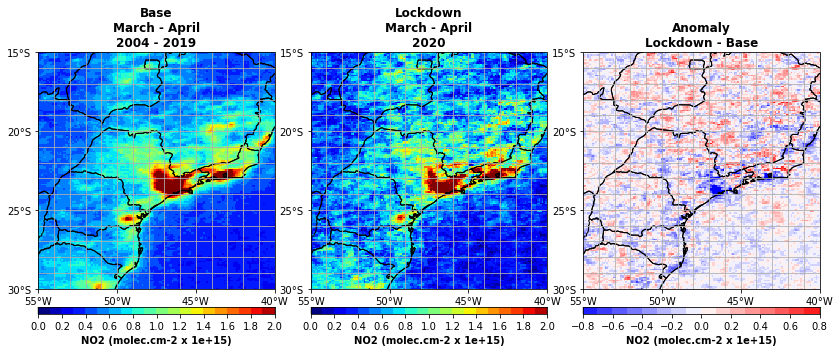

In [20]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(14, 6))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )        
    
# Plot data on these maps.
scale = 1e15

# Two first plots.
vmin = 0; vmax = 2; dv = 0.1

# Base period.
p = (DS_base.TroposphericNO2 / scale).plot(
        ax=axgr[0],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[0].set_title("Base\nMarch - April\n2004 - 2019", weight="bold")

# Lockdown period.
p = (DS_lock.TroposphericNO2 / scale).plot(
        ax=axgr[1],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[1].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[1].set_title("Lockdown\nMarch - April\n2020", weight="bold")

# Anomaly.
vmin = -0.8; vmax = 0.8; dv = 0.1
p = ((DS_lock.TroposphericNO2 - DS_base.TroposphericNO2) / scale).plot(
        ax=axgr[2],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.bwr,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[2].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[2].set_title("Anomaly\nLockdown - Base", weight="bold")

# Save figures.
plt.savefig(fig_path + "no2_omi_anomaly_southeast.jpg", dpi=200, bbox_inches="tight")

### Base period is 2015 - 2019

In [21]:
# March - April mean for the 2015-2019 period. 
mask_2015_2019 = np.logical_and(DS.time.dt.year >= 2015, DS.time.dt.year <= 2019)
mask_base = (mask_mar | mask_apr) & mask_2015_2019
DS_base = DS.sel(time=DS.time[mask_base]).mean("time")

CPU times: user 4.93 s, sys: 54.6 ms, total: 4.98 s
Wall time: 3.62 s


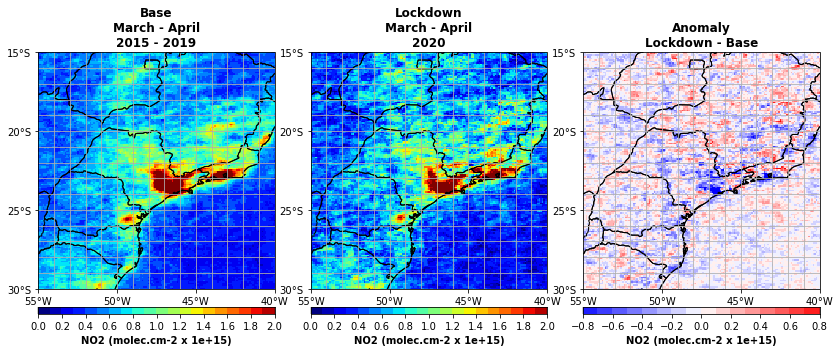

In [22]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(14, 6))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 3),
    axes_pad=0.5,
    cbar_location="bottom",
    cbar_mode="each",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([-55, -40, -30, -15], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-55, -40 + 5, 5), crs=projection)
    axis.set_yticks(np.arange(-30, -15 + 5, 5), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-55, -40 + 1, 1), ylocs=range(-30, -15 + 1, 1))  
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )        
    
# Plot data on these maps.
scale = 1e15

# Two first plots.
vmin = 0; vmax = 2; dv = 0.1

# Base period.
p = (DS_base.TroposphericNO2 / scale).plot(
        ax=axgr[0],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[0].set_title("Base\nMarch - April\n2015 - 2019", weight="bold")

# Lockdown period.
p = (DS_lock.TroposphericNO2 / scale).plot(
        ax=axgr[1],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[1].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[1].set_title("Lockdown\nMarch - April\n2020", weight="bold")

# Anomaly.
vmin = -0.8; vmax = 0.8; dv = 0.1
p = ((DS_lock.TroposphericNO2 - DS_base.TroposphericNO2) / scale).plot(
        ax=axgr[2],
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv, dv),
        cmap=plt.cm.bwr,
        add_colorbar=False,
        add_labels=False
)    

# Fill colorbar.        
cb = axgr.cbar_axes[2].colorbar(p)
cb.set_label_text(
    label="NO2 (" + DS.TroposphericNO2.attrs["Units"] + " x {:.0e})".format(scale), 
    weight="bold"
)
cb.cbar_axis.set_ticks(np.arange(vmin, vmax + 2*dv, 2*dv))  
axgr[2].set_title("Anomaly\nLockdown - Base", weight="bold")

# Save figures.
plt.savefig(fig_path + "no2_omi_anomaly_southeast2.jpg", dpi=200, bbox_inches="tight");

## Temporal evolution

CPU times: user 1.44 s, sys: 25.1 ms, total: 1.47 s
Wall time: 1.48 s


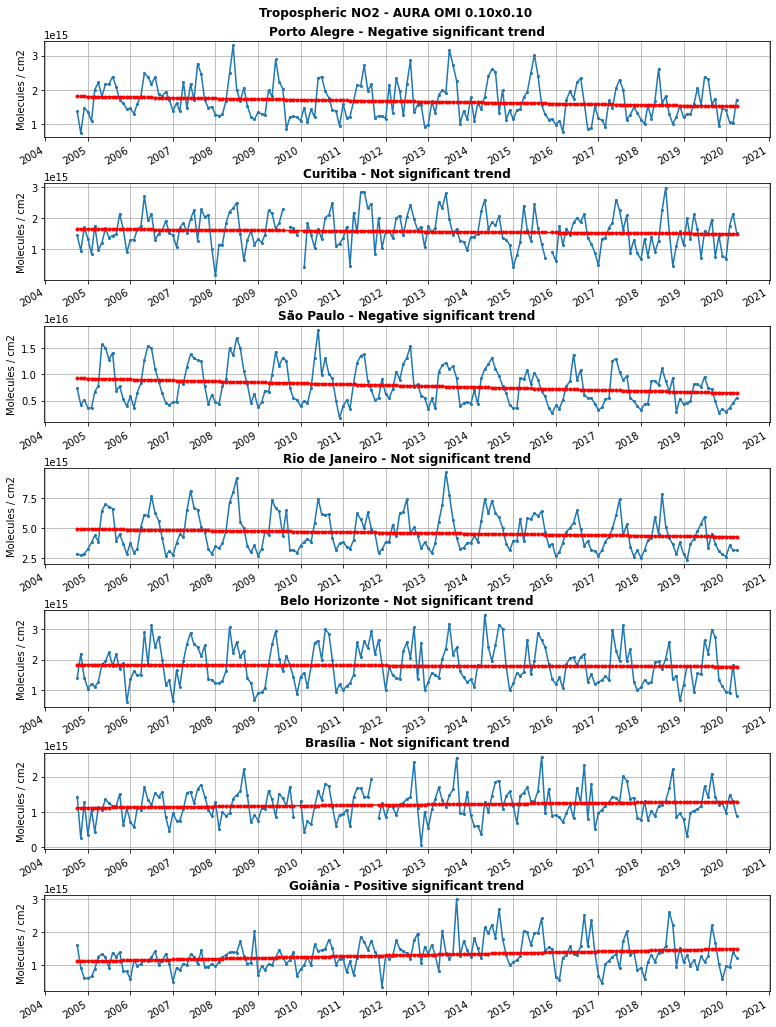

In [23]:
%%time

# Time Series for some cities.
CITIES = [
    "Porto Alegre", "Curitiba", "São Paulo", 
    "Rio de Janeiro", "Belo Horizonte", "Brasília", 
    "Goiânia"
]
# (lat, lon)
LOCATIONS = [
    (-30.0, -51.2), (-25.4, -49.3), (-23.6, -46.6),
    (-22.9, -43.2), (-19.9, -44.0), (-15.8, -47.9),
    (-16.7, -49.3)
]

# Make figure and axes.
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(13, 16))
months = mdates.YearLocator()
months_fmt = mdates.DateFormatter("%Y")

for CITY, LOCATION, axis in zip(CITIES, LOCATIONS, axes):
    
    lat, lon = LOCATION[0], LOCATION[1]
    DAloc = DS.TroposphericNO2.sel(lon=lon, lat=lat, method="nearest")
    
    DAloc.plot(ax=axis, marker="o", ms=2)
    axis.set_ylabel("Molecules / cm2")
    axis.set_xlabel(None)
    axis.xaxis.set_major_locator(months)
    axis.xaxis.set_major_formatter(months_fmt)
    axis.grid()

    # Linear regression.
    DATES = DAloc.time.values
    X = np.arange(DATES.shape[0])
    Y = DAloc.values
    masknan = np.isnan(Y)
    X = X[~masknan]
    Y = Y[~masknan]
    DATES = DATES[~masknan]
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    
    # Plot linear regression.
    Yhat = X * slope + intercept
    axis.plot(DATES, Yhat, ".-r")
    if p_value < 0.05:
        if slope > 0:
            SS = "Positive significant (not reliable) trend"
        else:
            SS = "Negative significant (not reliable) trend"
    else:
        SS = "Not significant trend"
    
    axis.set_title(CITY + " - " + SS, weight="bold")
    
# Further adjustments
plt.suptitle("Tropospheric NO2 - AURA OMI 0.10x0.10", weight="bold")
plt.subplots_adjust(top=0.95, hspace=0.475)

# Save figures.
plt.savefig(fig_path + "no2_omi_time_series_southeast.jpg", dpi=200, bbox_inches="tight");